# 02 - Exploratory Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
cur_path = "/content/drive/MyDrive/BDB 2025/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2025


In [2]:
# !pip install pyspark

# The entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("DataFrame").getOrCreate()

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 500)

from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType,IntegerType
from pyspark.ml.feature import StringIndexer,IndexToString,OneHotEncoder,VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression,MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [69]:
games = pd.read_csv('./data/games.csv')
players = pd.read_csv('./data/players.csv')
plays = pd.read_csv('./data/plays.csv')
player_play = pd.read_csv('./data/player_play.csv')
tracking = spark.read.option("header",'True').parquet('./data/games/tracking_week*.parquet')

In [ ]:
print(games.shape)
games.head()

(136, 9)


,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,9/8/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,9/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,9/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,9/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,9/11/2022,13:00:00,CIN,PIT,20,23


In [ ]:
print(players.shape)
players.head()

(1697, 7)


,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [ ]:
print(plays.shape)
print(plays[plays['isDropback']==1]['offenseFormation'].unique())
print(plays['receiverAlignment'].unique())
plays.head()

(16124, 51)
['EMPTY' 'SHOTGUN' 'PISTOL' 'I_FORM' 'SINGLEBACK' 'JUMBO' nan 'WILDCAT']
['3x2' '2x2' '3x1' nan '4x1' '2x1' '1x1' '2x0' '3x0' '1x0' '4x2' '3x3']


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap,passResult,passLength,targetX,targetY,playAction,dropbackType,dropbackDistance,passLocationType,timeToThrow,timeInTackleBox,timeToSack,passTippedAtLine,unblockedPressure,qbSpike,qbKneel,qbSneak,rushLocationType,penaltyYards,prePenaltyYardsGained,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,secRemainHalf
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,01:54,35,17,N,31,0.982017,0.017983,0.719313,EMPTY,3x2,10.0,C,6.0,36.69,16.51,False,TRADITIONAL,2.40,INSIDE_BOX,2.990,2.990,NaN,False,False,False,0,NaN,NaN,NaN,9,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone,1014
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,02:13,17,17,N,18,0.424356,0.575644,0.607746,EMPTY,3x2,9.0,C,4.0,20.83,20.49,False,TRADITIONAL,1.14,INSIDE_BOX,1.836,1.836,NaN,False,False,False,0,NaN,NaN,NaN,4,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone,133
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,02:00,3,17,N,30,0.006291,0.993709,-0.291485,SHOTGUN,2x2,12.0,C,-4.0,26.02,17.56,False,TRADITIONAL,3.20,INSIDE_BOX,2.236,2.236,NaN,False,False,False,0,NaN,NaN,NaN,6,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone,120
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,09:28,0,0,N,33,0.884223,0.115777,4.249382,SHOTGUN,2x2,11.0,C,-6.0,38.95,14.19,False,TRADITIONAL,3.02,INSIDE_BOX,2.202,2.202,NaN,False,False,False,0,NaN,NaN,NaN,4,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone,1468
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,02:16,10,10,N,37,0.410371,0.589629,3.928413,PISTOL,3x1,8.0,NaN,NaN,NaN,NaN,True,DESIGNED_RUN,2.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,INSIDE_LEFT,NaN,-1,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man,1036


In [ ]:
plays[plays['isDropback']==1]['offenseFormation'].value_counts()
# filter out WILDCAT and JUMBO?

,count
offenseFormation,
SHOTGUN,6553
SINGLEBACK,1306
EMPTY,1295
I_FORM,299
PISTOL,226
JUMBO,21
WILDCAT,13


In [ ]:
plays[(plays['isDropback']==1) & (plays['receiverAlignment'].isna()) & (plays['qbSpike'] != 1)].head()
# remove spikes from dataset
# In 03-FeatureEngineering, I remove where wasRunningRoute is null and all routes ran on spikes are null. Effectively the same thing
# alignment only null on spikes

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap,passResult,passLength,targetX,targetY,playAction,dropbackType,dropbackDistance,passLocationType,timeToThrow,timeInTackleBox,timeToSack,passTippedAtLine,unblockedPressure,qbSpike,qbKneel,qbSneak,rushLocationType,penaltyYards,prePenaltyYardsGained,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,secRemainHalf


In [ ]:
plays[(plays['isDropback']==1) & (plays['offenseFormation'].isna()) & (plays['qbSpike'] != 1)].head()
# remove spikes from dataset
# In 03-FeatureEngineering, I remove where wasRunningRoute is null and all routes ran on spikes are null. Effectively the same thing
# formation only null on spikes

In [ ]:
print(player_play.shape)
player_play.head()

(354727, 50)


,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,receivingYards,wasTargettedReceiver,yardageGainedAfterTheCatch,fumbles,fumbleLost,fumbleOutOfBounds,assistedTackle,forcedFumbleAsDefense,halfSackYardsAsDefense,passDefensed,quarterbackHit,sackYardsAsDefense,safetyAsDefense,soloTackle,tackleAssist,tackleForALoss,tackleForALossYardage,hadInterception,interceptionYards,fumbleRecoveries,fumbleRecoveryYards,penaltyYards,penaltyNames,wasInitialPassRusher,causedPressure,timeToPressureAsPassRusher,getOffTimeAsPassRusher,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,True,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,False,NaN,NaN,False,False,False,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Relationship between EPA and Complete/Incomplete Pass

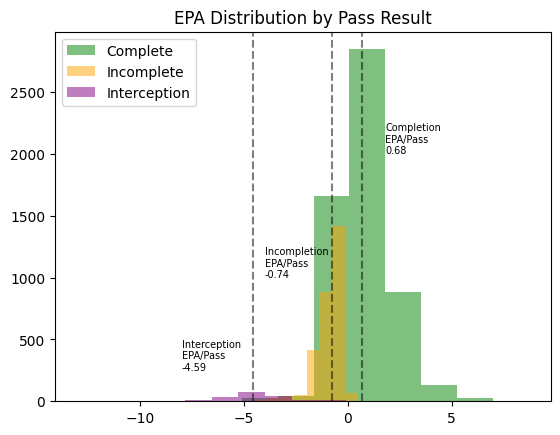

In [ ]:
# histogram with range of outcomes for EPA split by completion and incompletion
median_completion = plays[(plays['passResult']=='C') & (plays['playNullifiedByPenalty']=='N')]['expectedPointsAdded'].median()
median_incompletion = plays[(plays['passResult']=='I') & (plays['playNullifiedByPenalty']=='N')]['expectedPointsAdded'].median()
median_interception = plays[(plays['passResult']=='IN') & (plays['playNullifiedByPenalty']=='N')]['expectedPointsAdded'].median()

plt.hist(plays[plays['passResult']=='C']['expectedPointsAdded'],color='green',alpha=0.5)
plt.hist(plays[plays['passResult']=='I']['expectedPointsAdded'],color='orange',alpha=0.5)
plt.hist(plays[plays['passResult']=='IN']['expectedPointsAdded'],color='purple',alpha=0.5)
plt.legend(['Complete','Incomplete','Interception'],loc='upper left')
plt.title('EPA Distribution by Pass Result')
plt.axvline(x=median_interception,color='black',ls='--',alpha=0.5)
plt.axvline(x=median_incompletion,color='black',ls='--',alpha=0.5)
plt.axvline(x=median_completion,color='black',ls='--',alpha=0.5)
plt.annotate('Completion\nEPA/Pass\n'+ str(round(median_completion,2)), xy=(1.8,2000),fontsize=7)
plt.annotate('Incompletion\nEPA/Pass\n'+ str(round(median_incompletion,2)), xy=(-4,1000),fontsize=7)
plt.annotate('Interception\nEPA/Pass\n'+ str(round(median_interception,2)), xy=(-8,250),fontsize=7)
# plt.show()

plt.savefig(
    './visuals/EPADist.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

Median EPA/Pass is greatest for completions; therefore, we must prevent these plays. If we can predict routes, then we increase our chances of generating an interception which has the lowest EPA/Pass.

## Relationship between Route Ran and EPA

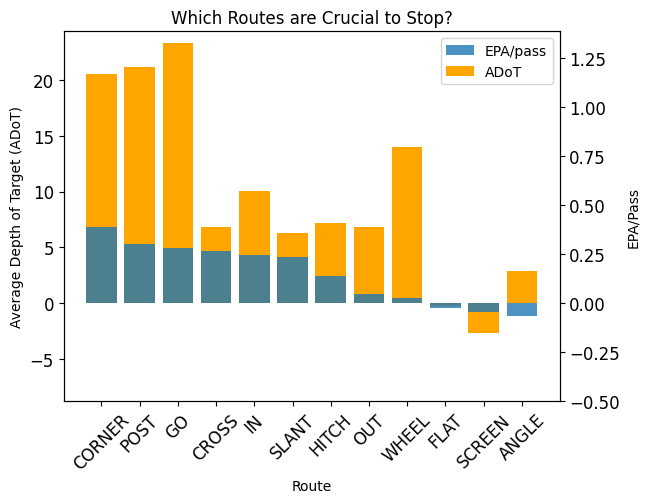

In [ ]:
# bar chart with route on the x-axis and EPA on the y-axis
# do longer routes lead to higher EPA?
reception = player_play[player_play['wasTargettedReceiver']==1]
routes = plays[['gameId','playId','expectedPointsAdded','passLength']].merge(reception[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
routes = routes.groupby(by='routeRan').agg({'expectedPointsAdded':'mean','passLength':'mean'}).sort_values(by='expectedPointsAdded',ascending=False).reset_index()

test = plt.bar(routes['routeRan'], routes['passLength'],alpha=1,color='orange')
plt.xticks(routes['routeRan'], routes['routeRan'], rotation=45)
plt.xlabel('Route')
plt.xticks(fontsize=12)
plt.ylabel('Average Depth of Target (ADoT)')
plt.yticks(fontsize=12)
plt.ylim(-8.8, max(routes['passLength']) + 1)

plt.twinx()

test1 = plt.bar(routes['routeRan'], routes['expectedPointsAdded'],alpha=0.8)
plt.ylabel('EPA/Pass')
plt.yticks(fontsize=12)
plt.ylim(-0.5, max(routes['expectedPointsAdded']) + 1)

plt.legend([test1,test],['EPA/pass','ADoT'])
plt.title('Which Routes are Crucial to Stop?')
# plt.show()

plt.savefig(
    './visuals/RouteEPA.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

EPA/Pass has a positive correlation with deep routes. Therefore, if we can predict when a deep route will be ran, then we can reduce the risk of getting beat deep. For example, if a GO route is predicted and the wide receiver fakes the hitch, then our defensive back will be less likely to bite on the hitch.

In [ ]:
# route target distribution
# use this as the baseline for the model
reception = player_play#[player_play['wasTargettedReceiver']==1]
routes = plays[['gameId','playId','expectedPointsAdded','passLength','isDropback']].merge(reception[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
routes = routes[~routes['routeRan'].isna()]
# total number of routes ran in the dataset
targets = routes.shape[0]
routes = routes.groupby(by='routeRan').agg({'playId':'count'}).reset_index()
routes['total_routes'] = targets
# create percentage of routes ran
routes['route_rate'] = routes['playId'] / routes['total_routes']
routes = routes.sort_values(by='route_rate',ascending=False).reset_index(drop=True)
routes[['routeRan','route_rate']].to_csv('./data/baseline_model.csv',index=False)
# routes

In [ ]:
# most common route by down
down_dist_route = plays[plays['isDropback']==True][['gameId','playId','expectedPointsAdded','passLength','isDropback','down']].merge(player_play[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
down_dist_route = down_dist_route[~down_dist_route['routeRan'].isna()]
routes_ran_down = down_dist_route.groupby(by='down').agg({'playId':'count'})
down_dist_route = down_dist_route.groupby(by=['down','routeRan']).agg({'playId':'count'}).reset_index()
down_dist_route = down_dist_route.merge(routes_ran_down,how='left',on='down')
down_dist_route['route_rate'] = down_dist_route['playId_x'] / down_dist_route['playId_y']
down_dist_route = down_dist_route.sort_values(by=['down','routeRan'],ascending=[True,False]).reset_index(drop=True)

In [ ]:
color_df = pd.DataFrame(down_dist_route['routeRan'].unique())
color_df.rename(columns={0:'routeRan'},inplace=True)
colors = ['#a9c77e','#dcae96','#1e203b','#ecbf7b','#852679','#4699cd','#e5d5bb','#008f51','#696ac9','#800020','#639867','#5d3526']
color_df['colors'] = colors
down_dist_route = down_dist_route.merge(color_df,how='left',on='routeRan')

In [ ]:
down_dist_route.shape[0]

48

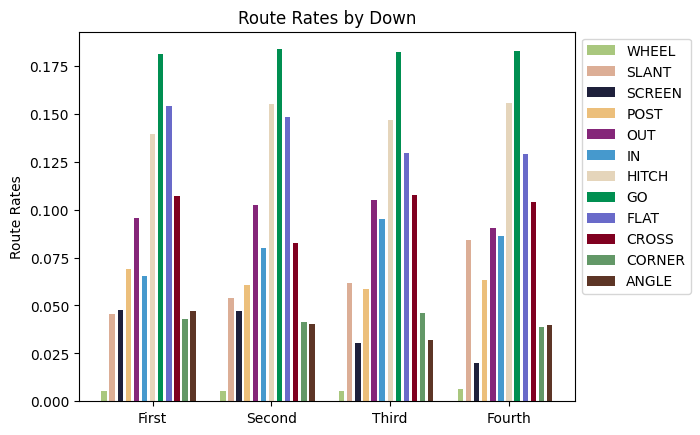

In [ ]:
width = 0.25  # the width of the bars
multiplier = 0
for i in range(0,down_dist_route.shape[0]):
  route = down_dist_route['routeRan'].iloc[i]
  down = down_dist_route['down'].iloc[i]
  route_rate = down_dist_route['route_rate'].iloc[i]
  color = down_dist_route['colors'].iloc[i]
  offset = width * multiplier
  if down == 1:
    plt.bar(down+offset, route_rate, width,color=color, label=route)
  elif down > 1:
    plt.bar(down+offset, route_rate, width,color=color)
  # plt.bar(down+offset, route_rate, width,color=color)
  multiplier += 1.5

plt.title('Route Rates by Down')
plt.ylabel('Route Rates')
# plt.tick_params(right = False ,
#                 labelbottom = False, bottom = False)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(ticks=[3.25,8.75,14.25,19.75] , labels=['First','Second','Third','Fourth'])

plt.savefig(
    './visuals/RouteRateByDown.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

Not pretty, but we can see that there is some variation in routes ran by down. This shows that we need to add some type of game-state context to inform our model that it's not always going to be the same average for each down. We can assume this would hold for other game states as well.

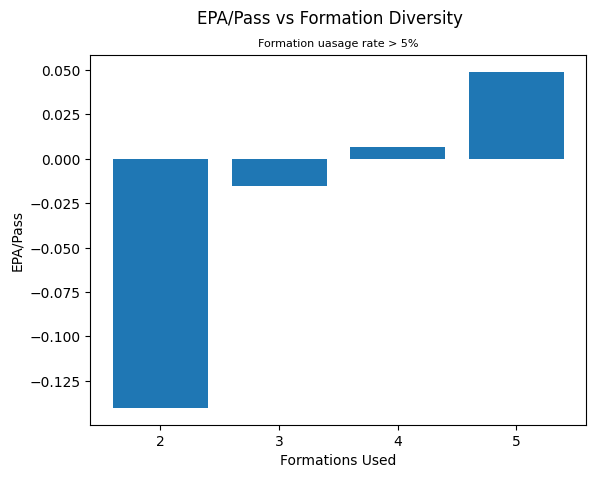

In [ ]:
# offenseFormation
# receiverAlignment
total_plays = plays.groupby('possessionTeam').agg({'playId':'count'}).reset_index()
plays_formation = plays.groupby(['possessionTeam','offenseFormation']).agg({'playId':'count'}).reset_index()
plays_formation = plays_formation.merge(total_plays,how='left',on='possessionTeam')
plays_formation['rate'] = plays_formation['playId_x'] / plays_formation['playId_y']
plays_formation = plays_formation[plays_formation['rate']>0.05]
plays_formation = plays_formation.groupby('possessionTeam').agg({'playId_y':'count'}).reset_index()
plays_epa = plays[plays['isDropback']==True].groupby('possessionTeam').agg({'expectedPointsAdded':'mean'}).reset_index()
plays_formation = plays_formation.merge(plays_epa,how='left',on='possessionTeam')
plays_formation = plays_formation.groupby('playId_y').agg({'expectedPointsAdded':'mean'}).reset_index()

plt.bar(plays_formation['playId_y'], plays_formation['expectedPointsAdded'])
# plt.title('EPA/Pass vs Formation Diversity')
plt.suptitle('EPA/Pass vs Formation Diversity',y=0.975)#,y=0.9, x=0.52,fontsize=34)
plt.title('Formation uasage rate > 5%',fontsize=8)#,y=0.9,x=0.5,fontsize=15)
plt.ylabel('EPA/Pass')
plt.xlabel('Formations Used')
plt.xticks(plays_formation['playId_y'], plays_formation['playId_y'])
plt.savefig(
    './visuals/EPAvsFormation.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

This graph shows that predictable offenses have a lower EPA/Pass. Therefore, if we are able to predict the route combinations, then we can decrease the offense's EPA/Pass.

In [ ]:
# time remaining
# include seconds remaining in the half because plays at the end of the quarter vs beginning of the quarter in the same half will behave the same
# whereas plays at the end of a half and beginning of the next half will behave differently
splitTime = plays['gameClock'].str.split(':', n=1, expand=True).rename(columns={0:'minutes',1:'seconds'})
plays['secRemainHalf'] = splitTime['minutes'].astype(int) * 60 + splitTime['seconds'].astype(int)
plays['secRemainHalf'] = np.where(plays['quarter'].isin([1,3]),plays['secRemainHalf']+900,plays['secRemainHalf'])

In [ ]:
plays.to_csv('./data/plays.csv',index=False)

# Time Before Snap

In [ ]:
tracking.show(5)

+----------+------+-----+-------+-------------------+-----------+--------------------+------------+----+-------------+-----+-----+----+----+----+------+------+-----+--------------+----------+-----------+------+-----+-----+-------+------+----+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+----------------------+--------------------+----------------+----------------+------------------+------------------+---------------------+-------------------+---------------+---------------+-----------------+------------------+---------------------+-------------------+---------------+---------------+-----------------+------------------+---------------------+-------------------+-----------

In [ ]:
max_frame = tracking.withColumn('frameId', tracking['frameId'].cast(IntegerType())).groupby('gameId','playId').agg({'frameId':'max'})
min_frame = tracking.withColumn('frameId', tracking['frameId'].cast(IntegerType())).groupby('gameId','playId').agg({'frameId':'min'})
# min_frame.printSchema()
max_min_frame = max_frame.join(min_frame,['gameId','playId'],'inner')
max_min_frame.withColumn('difference', max_min_frame['max(frameId)']-max_min_frame['min(frameId)']).agg({'difference':'mean'}).show()

+-----------------+
|  avg(difference)|
+-----------------+
|105.0536097980232|
+-----------------+



Average number of seconds in between each play is 105 / 25 frames per second (4.2 seconds). That's not enough time to filter out the presnap events.

# Offensive Formation Route Rate Breakdown

In [ ]:
# route target distribution
# use this as the baseline for the model
reception = player_play#[player_play['wasTargettedReceiver']==1]
routes = plays[['gameId','playId','expectedPointsAdded','passLength','isDropback']].merge(reception[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
routes = routes[~routes['routeRan'].isna()]
# total number of routes ran in the dataset
targets = routes.shape[0]
routes = routes.groupby(by='routeRan').agg({'playId':'count'}).reset_index()
routes['total_routes'] = targets
# create percentage of routes ran
routes['route_rate'] = routes['playId'] / routes['total_routes']
routes = routes.sort_values(by='route_rate',ascending=False).reset_index(drop=True)
# routes[['routeRan','route_rate']].to_csv('./data/baseline_model.csv',index=False)
# routes

In [ ]:
# most common route by formation
formation_dist_route = plays[plays['isDropback']==True][['gameId','playId','expectedPointsAdded','passLength','isDropback','offenseFormation']].merge(player_play[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
formation_dist_route = formation_dist_route[~formation_dist_route['routeRan'].isna()]
routes_ran_formation = formation_dist_route.groupby(by='offenseFormation').agg({'playId':'count'})
formation_dist_route = formation_dist_route.groupby(by=['offenseFormation','routeRan']).agg({'playId':'count'}).reset_index()
formation_dist_route = formation_dist_route.merge(routes_ran_formation,how='left',on='offenseFormation')
formation_dist_route['route_rate'] = formation_dist_route['playId_x'] / formation_dist_route['playId_y']
formation_dist_route = formation_dist_route.sort_values(by=['offenseFormation','routeRan'],ascending=[True,False]).reset_index(drop=True)
formation_dist_route['route_rate'] = (formation_dist_route['route_rate']*100).round(2)

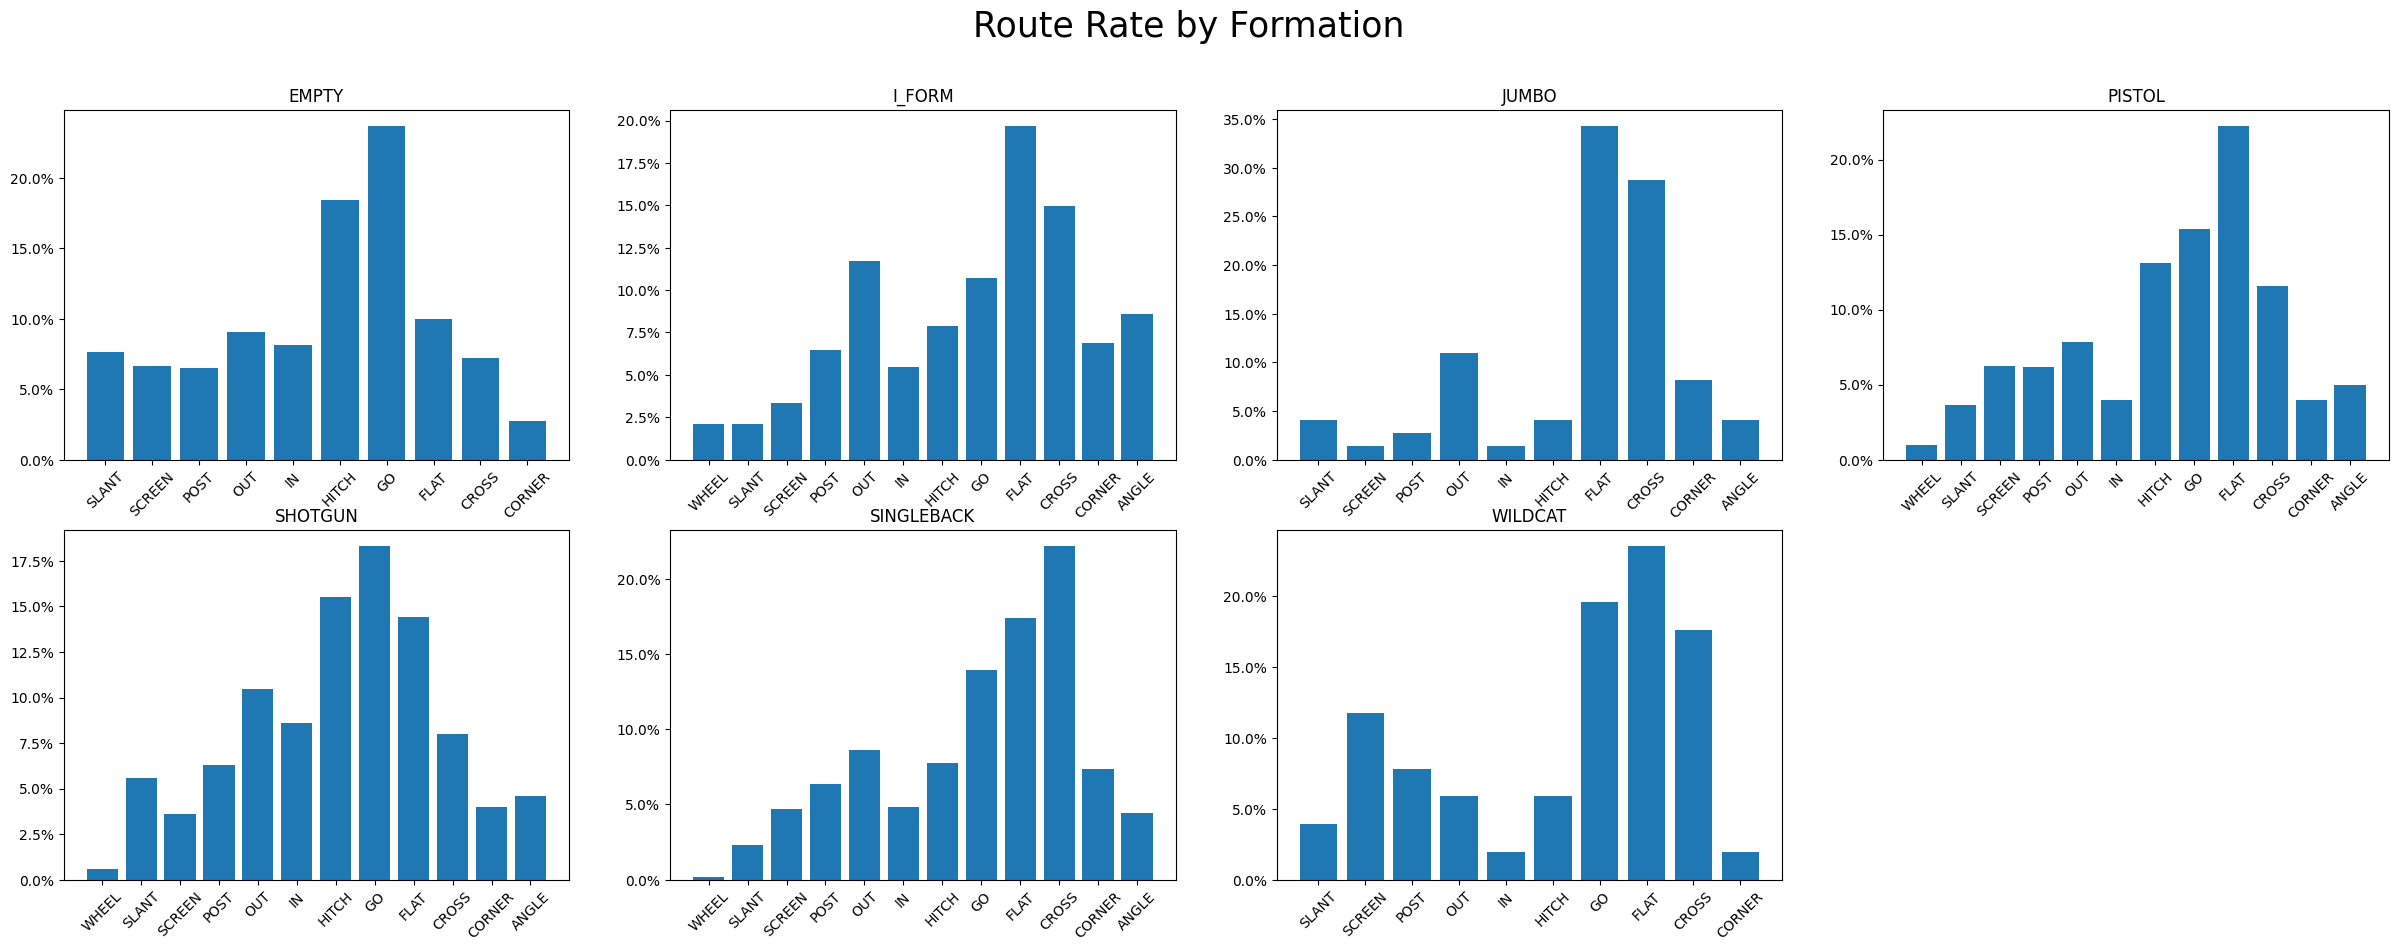

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(30,10),facecolor='#ffff')
formations = formation_dist_route['offenseFormation'].unique()

for formation in range(len(formation_dist_route['offenseFormation'].unique())):
  if formation <= 3:
    ax[0][formation].bar(formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['routeRan'], formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['route_rate'])
    ax[0][formation].set_xticks(formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['routeRan'], formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['routeRan'], rotation=45)
    ax[0][formation].set_title(formations[formation])
    ax[0][formation].yaxis.set_major_formatter(mtick.PercentFormatter())

  else:
    ax[1][formation-4].bar(formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['routeRan'], formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['route_rate'].round(2))
    ax[1][formation-4].set_xticks(formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['routeRan'], formation_dist_route[formation_dist_route['offenseFormation']==formations[formation]]['routeRan'], rotation=45)
    ax[1][formation-4].set_title(formations[formation])
    ax[1][formation-4].yaxis.set_major_formatter(mtick.PercentFormatter())

# remove bottom right graph
ax[1][3].tick_params(left = False, right = False , labelleft = False ,
              labelbottom = False, bottom = False)
ax[1][3].set_axis_off()

fig.suptitle('Route Rate by Formation', fontsize=25)

plt.savefig(
    './visuals/RouteRateByFormation.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

Looks like routes are ran at different routes across the formations; therefore, using an offensive formation feature in the model could help performance. Additionally, some routes aren't even ran in some formations which will significantly help the model because it can reduce the number of possible predictions when certain formations are lined up.

# Route Rate by Receiver Alignment

In [ ]:
# receiver alignment
# most common route by alignment
alignment_dist_route = plays[plays['isDropback']==True][['gameId','playId','expectedPointsAdded','passLength','isDropback','receiverAlignment']].merge(player_play[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
alignment_dist_route = alignment_dist_route[~alignment_dist_route['routeRan'].isna()]
routes_ran_alignment = alignment_dist_route.groupby(by='receiverAlignment').agg({'playId':'count'})
alignment_dist_route = alignment_dist_route.groupby(by=['receiverAlignment','routeRan']).agg({'playId':'count'}).reset_index()
alignment_dist_route = alignment_dist_route.merge(routes_ran_alignment,how='left',on='receiverAlignment')
alignment_dist_route['route_rate'] = alignment_dist_route['playId_x'] / alignment_dist_route['playId_y']
alignment_dist_route = alignment_dist_route.sort_values(by=['receiverAlignment','routeRan'],ascending=[True,False]).reset_index(drop=True)
alignment_dist_route['route_rate'] = (alignment_dist_route['route_rate']*100).round(2)

In [ ]:
alignment_dist_route['receiverAlignment'].unique()

array(['1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '3x3',
       '4x1'], dtype=object)

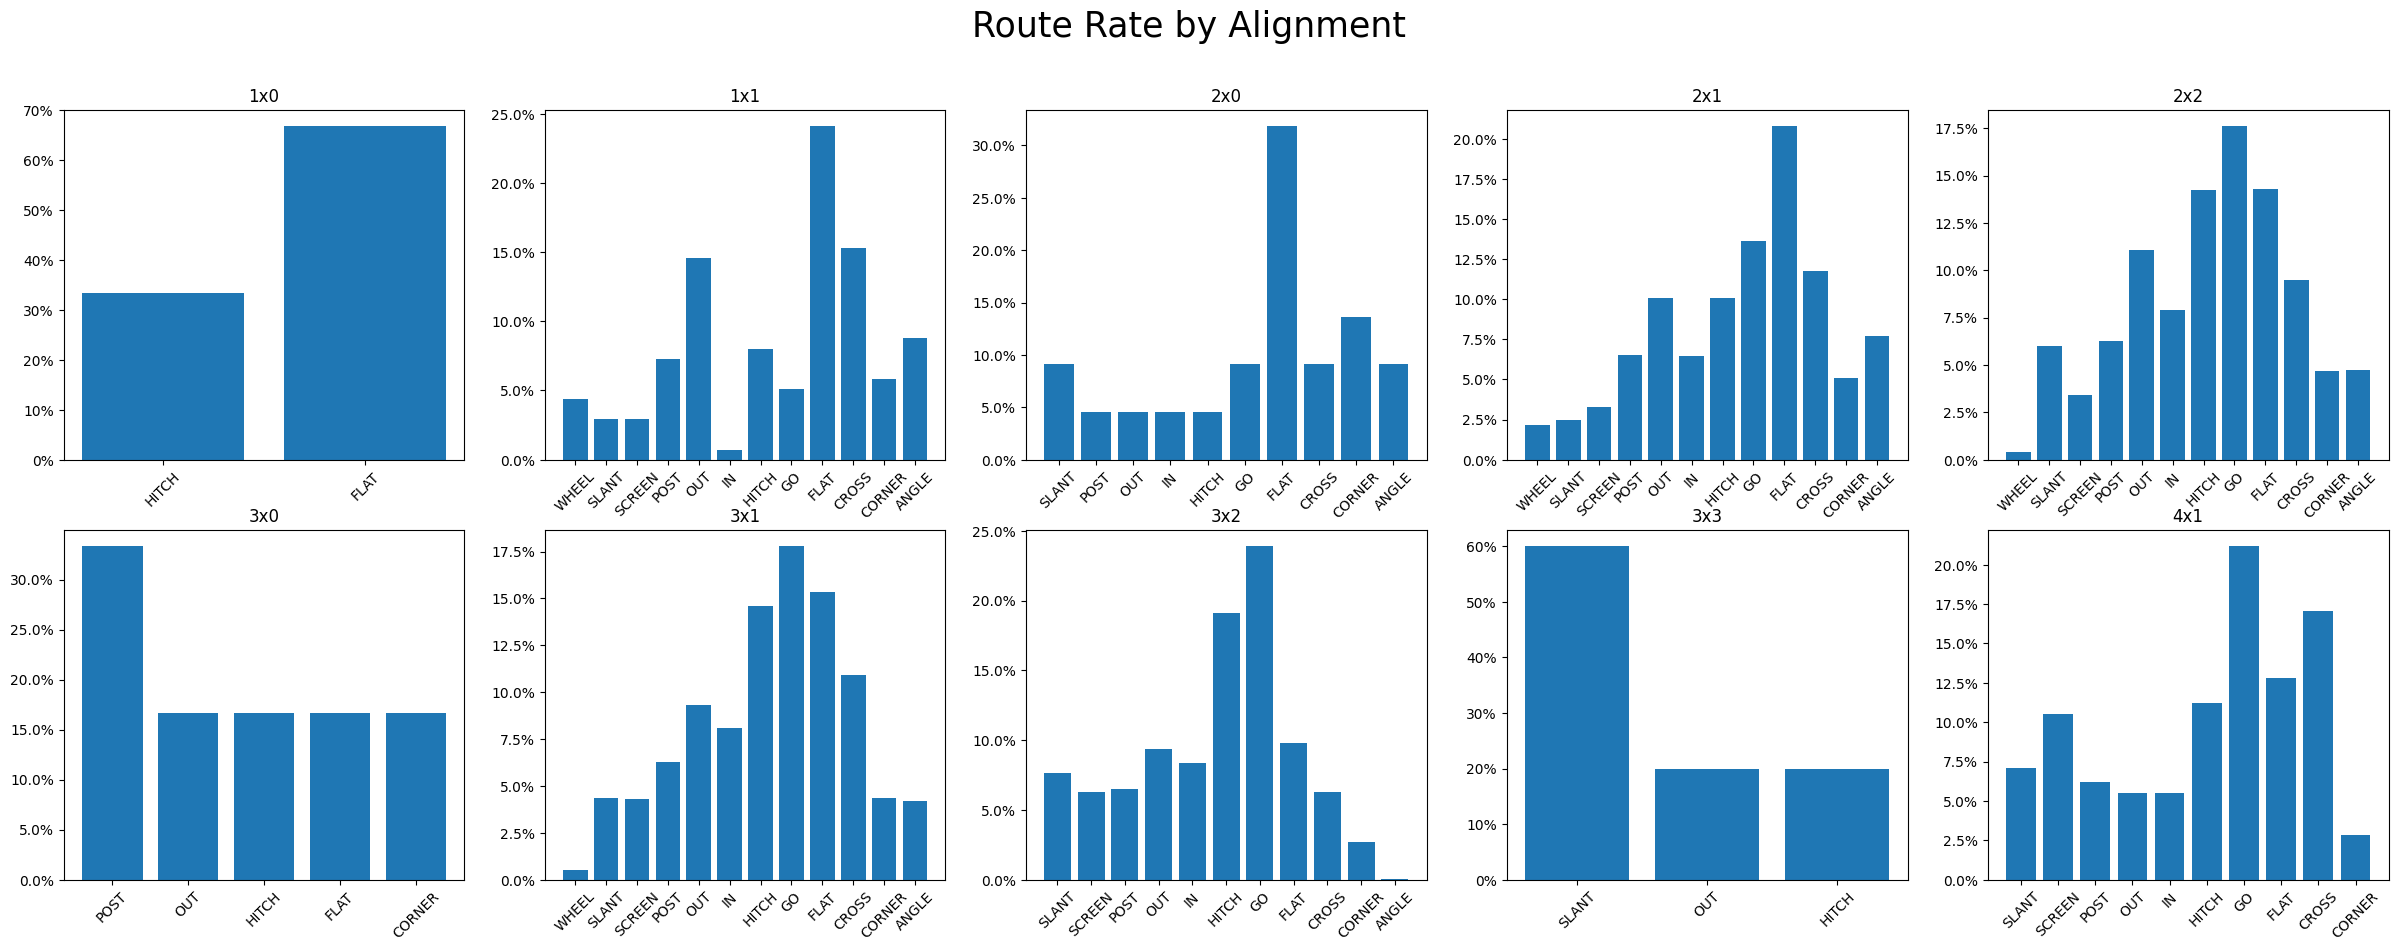

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(30,10),facecolor='#ffff')
formations = alignment_dist_route['receiverAlignment'].unique()

for formation in range(len(alignment_dist_route['receiverAlignment'].unique())):
  if formation <= 4:
    ax[0][formation].bar(alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['routeRan'], alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['route_rate'])
    ax[0][formation].set_xticks(alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['routeRan'], alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['routeRan'], rotation=45)
    ax[0][formation].set_title(formations[formation])
    ax[0][formation].yaxis.set_major_formatter(mtick.PercentFormatter())

  else:
    ax[1][formation-5].bar(alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['routeRan'], alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['route_rate'].round(2))
    ax[1][formation-5].set_xticks(alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['routeRan'], alignment_dist_route[alignment_dist_route['receiverAlignment']==formations[formation]]['routeRan'], rotation=45)
    ax[1][formation-5].set_title(formations[formation])
    ax[1][formation-5].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle('Route Rate by Alignment', fontsize=25)

plt.savefig(
    './visuals/RouteRateByAlignment.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

Same as formation, there is variety in receiver alignment where some routes are not ran in particular alignments. On top of that, routes that are ran in multiple alignments tend to be ran at different rates. There is enough variety here to include receiver alignment in the model.

In [ ]:
print(plays[plays['receiverAlignment']=='1x0'].shape)
print(plays[plays['receiverAlignment']=='1x1'].shape)
print(plays[plays['receiverAlignment']=='2x0'].shape)
print(plays[plays['receiverAlignment']=='2x1'].shape)
print(plays[plays['receiverAlignment']=='2x2'].shape)
print(plays[plays['receiverAlignment']=='3x0'].shape)
print(plays[plays['receiverAlignment']=='3x1'].shape)
print(plays[plays['receiverAlignment']=='3x2'].shape)
print(plays[plays['receiverAlignment']=='3x3'].shape)
print(plays[plays['receiverAlignment']=='4x1'].shape)
# filter out 1x0, 3x0, and 3x3?

(8, 51)
(160, 51)
(45, 51)
(1824, 51)
(6483, 51)
(9, 51)
(6044, 51)
(1232, 51)
(1, 51)
(129, 51)


In [ ]:
plays_games = plays.merge(games,how='left',on='gameId')
plays_games['possessionsTeamWinProbability'] = np.where(plays_games['possessionTeam'] == plays_games['homeTeamAbbr'], plays_games['preSnapHomeTeamWinProbability'], plays_games['preSnapVisitorTeamWinProbability'])
plays_games[['possessionTeam','homeTeamAbbr','visitorTeamAbbr','preSnapHomeTeamWinProbability','possessionsTeamWinProbability']].head()

,possessionTeam,homeTeamAbbr,visitorTeamAbbr,preSnapHomeTeamWinProbability,possessionsTeamWinProbability
0,CIN,CIN,ATL,0.982017,0.982017
1,CIN,DAL,CIN,0.424356,0.575644
2,HOU,HOU,TEN,0.006291,0.006291
3,KC,KC,TEN,0.884223,0.884223
4,BAL,TB,BAL,0.410371,0.589629


# Route Rate by Team

In [ ]:
# route target distribution
# use this as the baseline for the model
reception = player_play#[player_play['wasTargettedReceiver']==1]
routes = plays[['gameId','playId','expectedPointsAdded','passLength','isDropback']].merge(reception[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
routes = routes[~routes['routeRan'].isna()]
# total number of routes ran in the dataset
targets = routes.shape[0]
routes = routes.groupby(by='routeRan').agg({'playId':'count'}).reset_index()
routes['total_routes'] = targets
# create percentage of routes ran
routes['route_rate'] = routes['playId'] / routes['total_routes']
routes = routes.sort_values(by='route_rate',ascending=False).reset_index(drop=True)
# routes[['routeRan','route_rate']].to_csv('./data/baseline_model.csv',index=False)
# routes

In [ ]:
# team
# most common route by alignment
alignment_dist_team = plays[plays['isDropback']==True][['gameId','playId','expectedPointsAdded','passLength','isDropback','possessionTeam']].merge(player_play[['gameId','playId','routeRan']],how='left',on=['gameId','playId'])
alignment_dist_team = alignment_dist_team[~alignment_dist_team['routeRan'].isna()]
routes_ran_team = alignment_dist_team.groupby(by='possessionTeam').agg({'playId':'count'})
alignment_dist_team = alignment_dist_team.groupby(by=['possessionTeam','routeRan']).agg({'playId':'count'}).reset_index()
alignment_dist_team = alignment_dist_team.merge(routes_ran_team,how='left',on='possessionTeam')
alignment_dist_team['route_rate'] = alignment_dist_team['playId_x'] / alignment_dist_team['playId_y']
alignment_dist_team = alignment_dist_team.sort_values(by=['possessionTeam','routeRan'],ascending=[True,False]).reset_index(drop=True)
alignment_dist_team['route_rate'] = (alignment_dist_team['route_rate']*100).round(2)

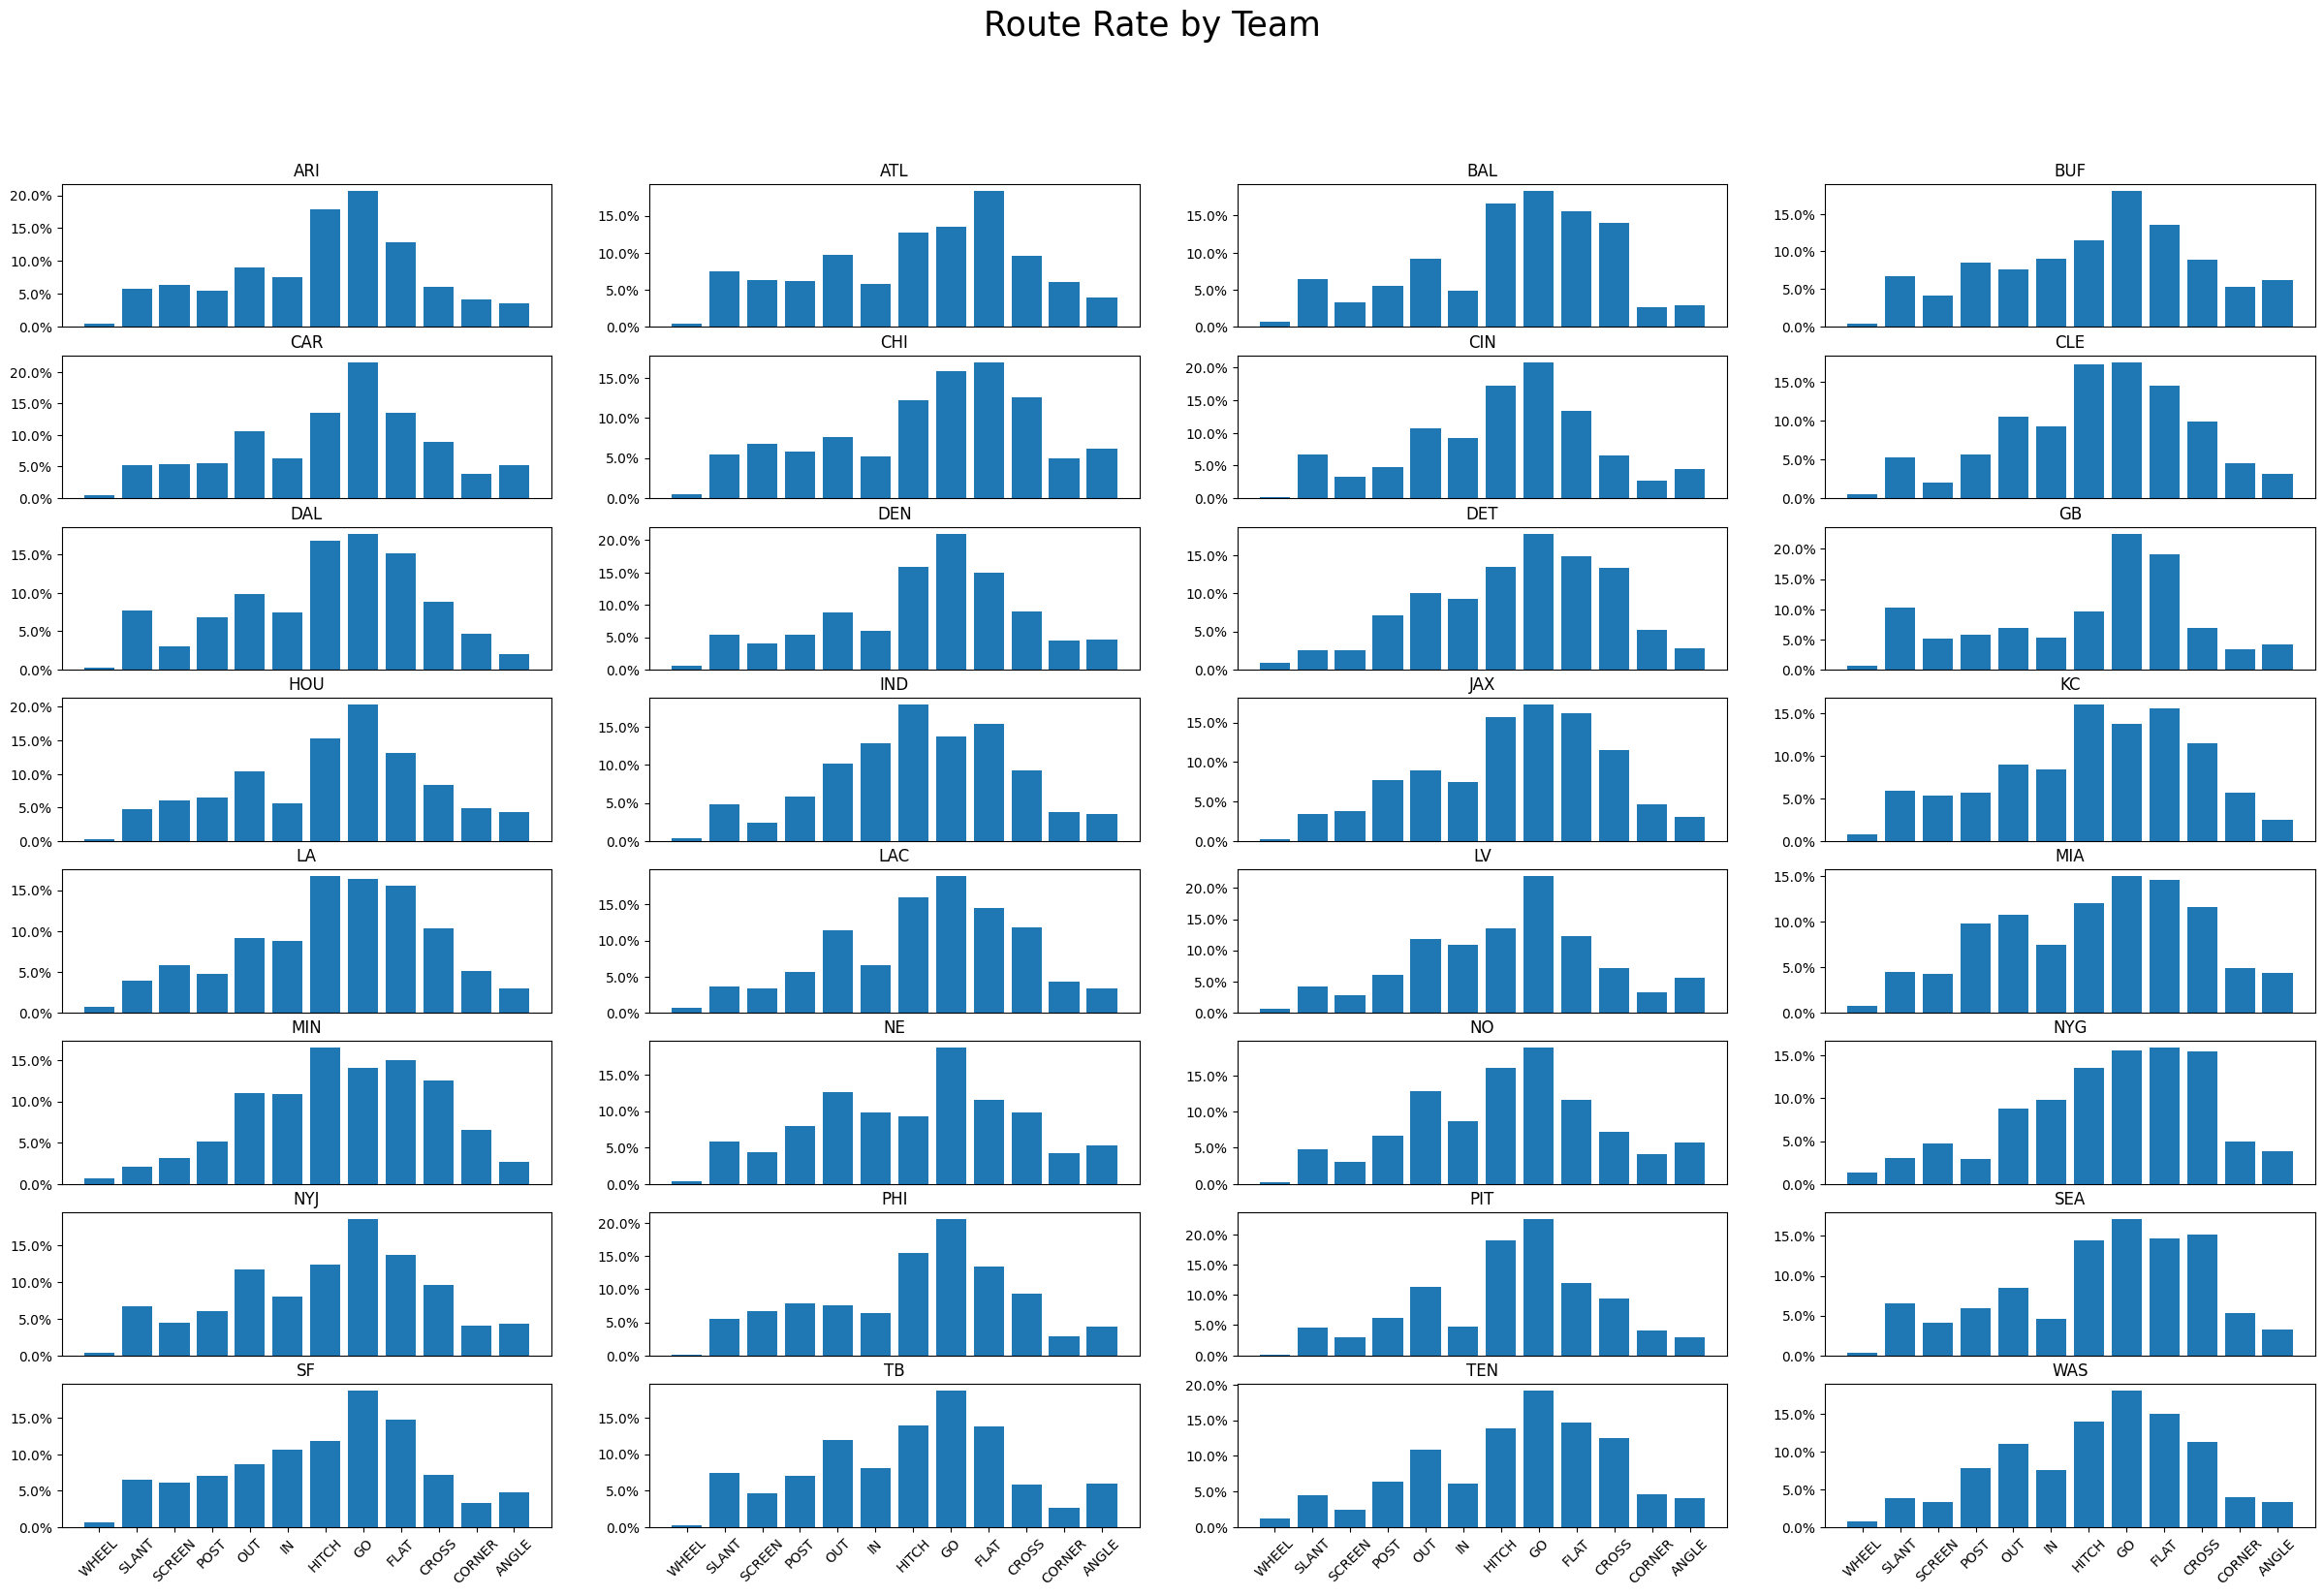

In [ ]:
fig, ax = plt.subplots(8,4,figsize=(30,18),facecolor='#ffff')
formations = alignment_dist_team['possessionTeam'].unique()

for formation in range(len(alignment_dist_team['possessionTeam'].unique())):
  if formation <= 3:
    ax[0][formation].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'])
    ax[0][formation].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[0][formation].set_title(formations[formation])
    ax[0][formation].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0][formation].get_xaxis().set_visible(False)


  elif formation <= 7:
    ax[1][formation-4].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[1][formation-4].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[1][formation-4].set_title(formations[formation])
    ax[1][formation-4].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1][formation-4].get_xaxis().set_visible(False)

  elif formation <= 11:
    ax[2][formation-8].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[2][formation-8].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[2][formation-8].set_title(formations[formation])
    ax[2][formation-8].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[2][formation-8].get_xaxis().set_visible(False)

  elif formation <= 15:
    ax[3][formation-12].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[3][formation-12].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[3][formation-12].set_title(formations[formation])
    ax[3][formation-12].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[3][formation-12].get_xaxis().set_visible(False)

  elif formation <= 19:
    ax[4][formation-16].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[4][formation-16].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[4][formation-16].set_title(formations[formation])
    ax[4][formation-16].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[4][formation-16].get_xaxis().set_visible(False)

  elif formation <= 23:
    ax[5][formation-20].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[5][formation-20].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[5][formation-20].set_title(formations[formation])
    ax[5][formation-20].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[5][formation-20].get_xaxis().set_visible(False)

  elif formation <= 27:
    ax[6][formation-24].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[6][formation-24].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[6][formation-24].set_title(formations[formation])
    ax[6][formation-24].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[6][formation-24].get_xaxis().set_visible(False)

  elif formation <= 31:
    ax[7][formation-28].bar(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['route_rate'].round(2))
    ax[7][formation-28].set_xticks(alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], alignment_dist_team[alignment_dist_team['possessionTeam']==formations[formation]]['routeRan'], rotation=45)
    ax[7][formation-28].set_title(formations[formation])
    ax[7][formation-28].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle('Route Rate by Team', fontsize=25)

plt.savefig(
    './visuals/RouteRateByTeam.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

This confirms that teams have different tendencies. For example, NYG runs FLAT and CROSS just as much as GO whereas TEN runs GO 5% more than FLAT and CROSS. Each team has its own tendencies because of game script (determined by win prob) and QB ability

# Routes by Yardline

How often are routes ran in each segment of the field?

In [ ]:
routeYardline = player_play[player_play['routeRan'].notna()][['gameId','playId','routeRan']].merge(plays[plays['isDropback']==True][['gameId','playId','absoluteYardlineNumber']], on=['gameId','playId'], how='left')
# group absoluteYardlineNumber by increments of 10
# List of conditions
conditions = [
      (routeYardline['absoluteYardlineNumber'] > 10) & (routeYardline['absoluteYardlineNumber'] <= 20)
    , (routeYardline['absoluteYardlineNumber'] > 20) & (routeYardline['absoluteYardlineNumber'] <= 30)
    , (routeYardline['absoluteYardlineNumber'] > 30) & (routeYardline['absoluteYardlineNumber'] <= 40)
    , (routeYardline['absoluteYardlineNumber'] > 40) & (routeYardline['absoluteYardlineNumber'] <= 50)
    , (routeYardline['absoluteYardlineNumber'] > 50) & (routeYardline['absoluteYardlineNumber'] <= 60)
    , (routeYardline['absoluteYardlineNumber'] > 60) & (routeYardline['absoluteYardlineNumber'] <= 70)
    , (routeYardline['absoluteYardlineNumber'] > 70) & (routeYardline['absoluteYardlineNumber'] <= 80)
    , (routeYardline['absoluteYardlineNumber'] > 80) & (routeYardline['absoluteYardlineNumber'] <= 90)
    , (routeYardline['absoluteYardlineNumber'] > 90) & (routeYardline['absoluteYardlineNumber'] <= 100)
    , (routeYardline['absoluteYardlineNumber'] > 100) & (routeYardline['absoluteYardlineNumber'] <= 110)
]
# List of values to return
choices  = [
      "0-10"
    , "10-20"
    , "20-30"
    , "30-40"
    , "40-50"
    , "50-60"
    , "60-70"
    , "70-80"
    , "80-90"
    , "90-100"
]
routeYardline['yardlineGroup'] = np.select(conditions,choices)
routes_ran_team = routeYardline.groupby(by='yardlineGroup').agg({'playId':'count'})
routeYardline = routeYardline.groupby(by=['yardlineGroup','routeRan']).agg({'playId':'count'}).reset_index()
routeYardline = routeYardline.merge(routes_ran_team,how='left',on='yardlineGroup')
routeYardline['route_rate'] = routeYardline['playId_x'] / routeYardline['playId_y']
routeYardline = routeYardline.sort_values(by=['yardlineGroup','routeRan'],ascending=[True,False]).reset_index(drop=True)
routeYardline['route_rate'] = (routeYardline['route_rate']*100).round(2)
# routeYardline

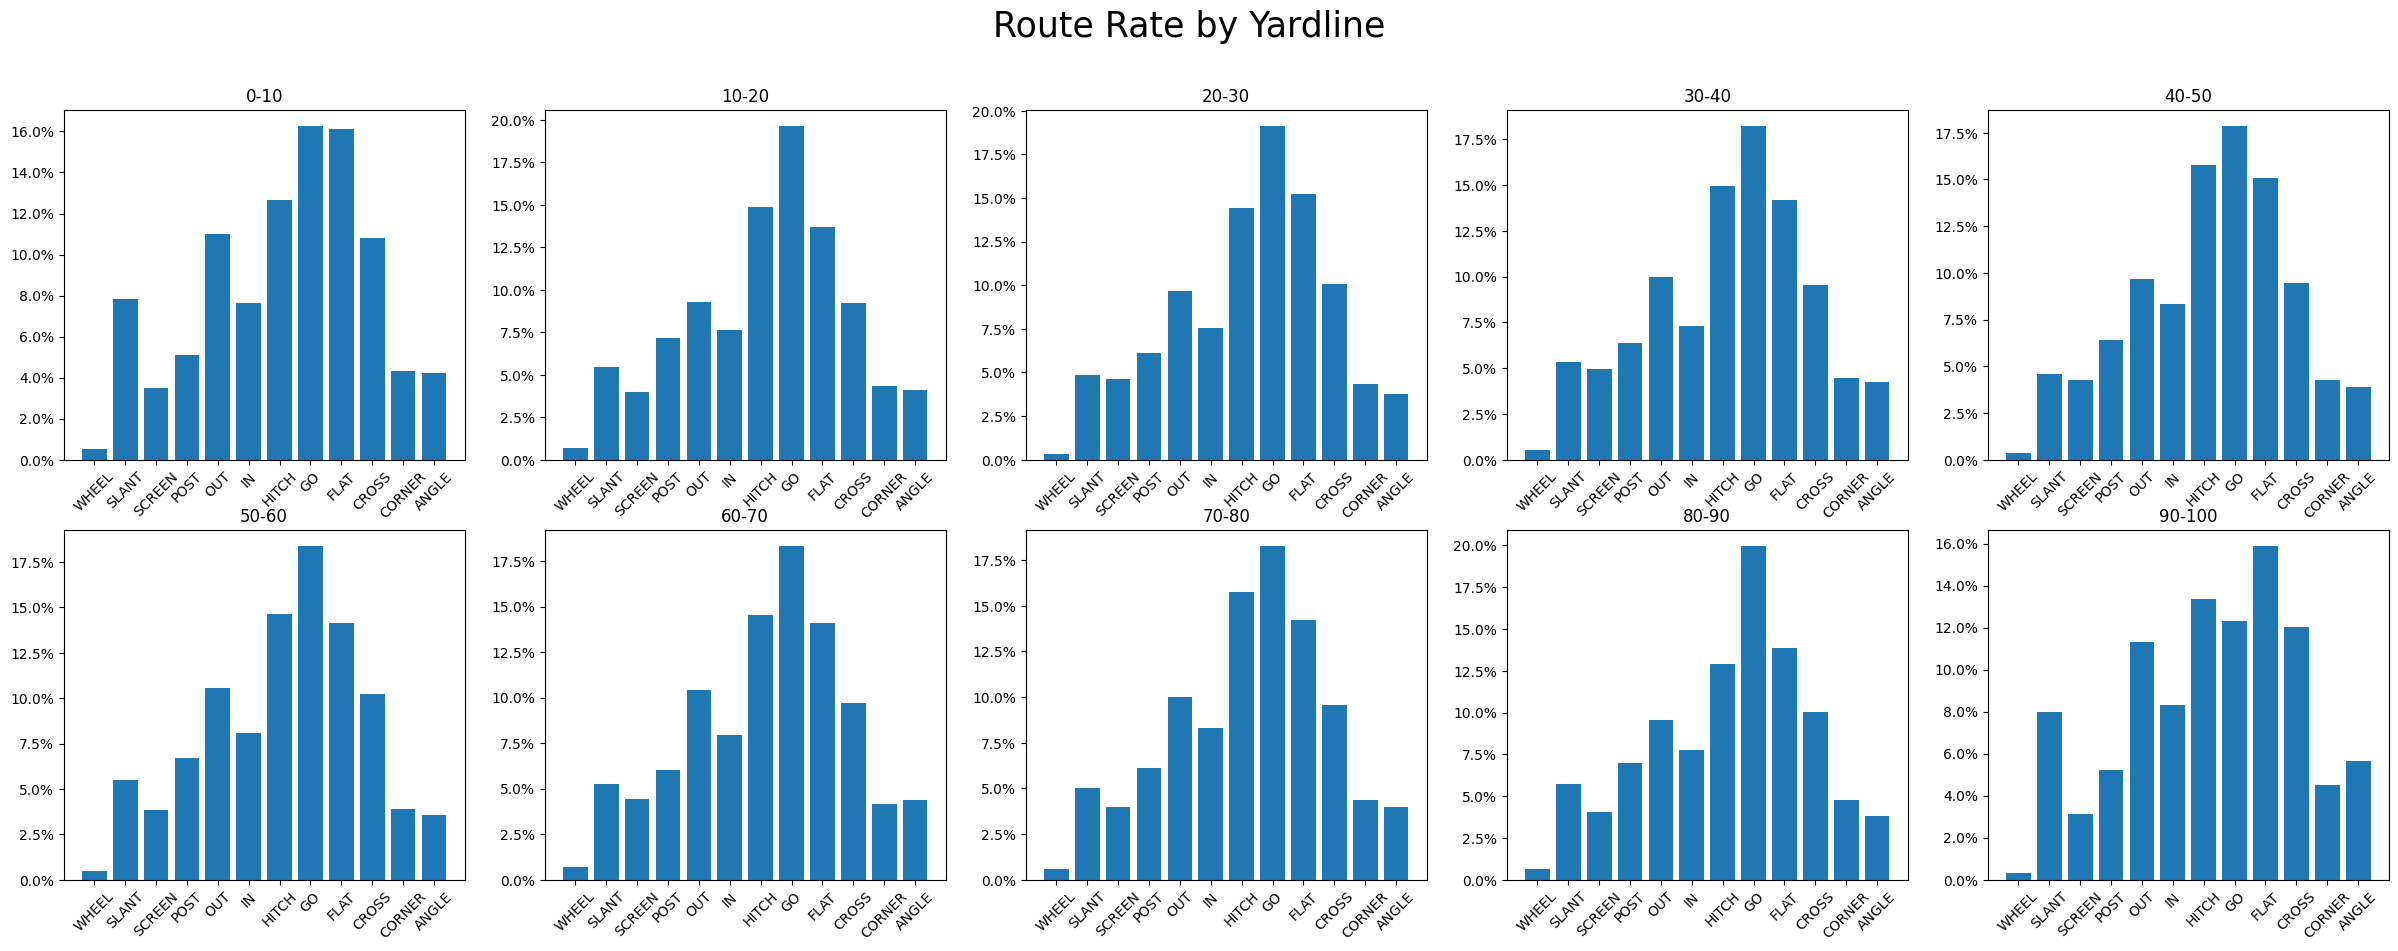

In [ ]:
fig, ax = plt.subplots(2,5,figsize=(30,10),facecolor='#ffff')
formations = routeYardline['yardlineGroup'].unique()

for formation in range(len(routeYardline['yardlineGroup'].unique())):
  if formation <= 4:
    ax[0][formation].bar(routeYardline[routeYardline['yardlineGroup']==formations[formation]]['routeRan'], routeYardline[routeYardline['yardlineGroup']==formations[formation]]['route_rate'])
    ax[0][formation].set_xticks(routeYardline[routeYardline['yardlineGroup']==formations[formation]]['routeRan'], routeYardline[routeYardline['yardlineGroup']==formations[formation]]['routeRan'], rotation=45)
    ax[0][formation].set_title(formations[formation])
    ax[0][formation].yaxis.set_major_formatter(mtick.PercentFormatter())

  else:
    ax[1][formation-5].bar(routeYardline[routeYardline['yardlineGroup']==formations[formation]]['routeRan'], routeYardline[routeYardline['yardlineGroup']==formations[formation]]['route_rate'].round(2))
    ax[1][formation-5].set_xticks(routeYardline[routeYardline['yardlineGroup']==formations[formation]]['routeRan'], routeYardline[routeYardline['yardlineGroup']==formations[formation]]['routeRan'], rotation=45)
    ax[1][formation-5].set_title(formations[formation])
    ax[1][formation-5].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle('Route Rate by Yardline', fontsize=25)

plt.savefig(
    './visuals/RouteRateByYardline.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

# Distant to LOS

Is there a difference in the routes ran by players on the LOS and routes ran by players in the backfield? If there is a difference, then I think it would be important to include the route runners' relative distance to the LOS in the model.

In [70]:
trackingYdsLOS = tracking.select('gameId','playId','nflId','x','playDirection').groupby(['gameId','playId','nflId','playDirection']).agg({'x':'mean'}).toPandas()
# trackingYdsLOS.head()

In [71]:
trackingYdsLOS['gameId'] = trackingYdsLOS['gameId'].astype(int)
trackingYdsLOS['playId'] = trackingYdsLOS['playId'].astype(int)
ydsToLOS = trackingYdsLOS.merge(plays[(~plays['playDescription'].str.contains('No Huddle')) & (plays['secRemainHalf']>120)][['gameId','playId','absoluteYardlineNumber']],how='left',on=['gameId','playId'])
ydsToLOS['distToLOS'] = np.where(ydsToLOS['playDirection']=='left', ydsToLOS['avg(x)'] - ydsToLOS['absoluteYardlineNumber'], ydsToLOS['absoluteYardlineNumber'] - ydsToLOS['avg(x)'])
ydsToLOS['distToLOS'] = np.floor(ydsToLOS['distToLOS'])
# ydsToLOS.head()

In [ ]:
ydsToLOS.sort_values(by='distToLOS').head()

,gameId,playId,nflId,playDirection,avg(x),absoluteYardlineNumber,distToLOS
22189,2022091500,1717,47839,right,24.750204,21,-4.0
9481,2022092508,3309,47859,left,61.563939,62,-1.0
32630,2022092506,3633,54475,left,61.835000,62,-1.0
24431,2022101601,4414,52595,right,73.531538,73,-1.0
12395,2022100906,2030,42412,left,59.711109,60,-1.0


In [72]:
ydsToLOS = ydsToLOS.sort_values(by='distToLOS')
for i in range(ydsToLOS[ydsToLOS['distToLOS']<0].shape[0]):
  playDesc = ydsToLOS.merge(plays[['gameId','playId','playDescription']],on=['gameId','playId'],how='left').sort_values(by='distToLOS').iloc[i]['playDescription']
  secRemainHalf = ydsToLOS.merge(plays[['gameId','playId','playDescription','secRemainHalf']],on=['gameId','playId'],how='left').sort_values(by='distToLOS').iloc[i]['secRemainHalf']
  print(playDesc, secRemainHalf)
# most of the plays where players' avg dist to LOS was negative were either no huddle plays or had little time remaining

(5:07) P.Mahomes pass short right to T.Kelce to SF 37 for 27 yards (F.Warner). 26 YAC 1207
(9:48) (Shotgun) Z.Wilson pass short right to C.Davis to PIT 17 for 22 yards (T.Norwood, A.Maulet). 588


In [73]:
ydsToLOS['nflId'] = trackingYdsLOS['nflId'].astype(int)
routeYdsToLOS = player_play[player_play['routeRan'].notna()][['gameId','playId','routeRan','nflId']].merge(ydsToLOS, on=['gameId','playId','nflId'], how='left')
routes_ran_LOS = routeYdsToLOS.groupby(by='distToLOS').agg({'playId':'count'})
routeYdsToLOS = routeYdsToLOS.groupby(by=['distToLOS','routeRan']).agg({'playId':'count'}).reset_index()
routeYdsToLOS = routeYdsToLOS.merge(routes_ran_LOS,how='left',on='distToLOS')
routeYdsToLOS['route_rate'] = routeYdsToLOS['playId_x'] / routeYdsToLOS['playId_y']
routeYdsToLOS = routeYdsToLOS.sort_values(by=['distToLOS','routeRan'],ascending=[True,False]).reset_index(drop=True)
routeYdsToLOS['route_rate'] = (routeYdsToLOS['route_rate']*100).round(2)
routeYdsToLOS = routeYdsToLOS[(routeYdsToLOS['distToLOS']>=0) & (routeYdsToLOS['distToLOS']<=10)]
routeYdsToLOS.head()

,distToLOS,routeRan,playId_x,playId_y,route_rate
2,0.0,SLANT,86,1334,6.45
3,0.0,SCREEN,21,1334,1.57
4,0.0,POST,141,1334,10.57
5,0.0,OUT,139,1334,10.42
6,0.0,IN,136,1334,10.19


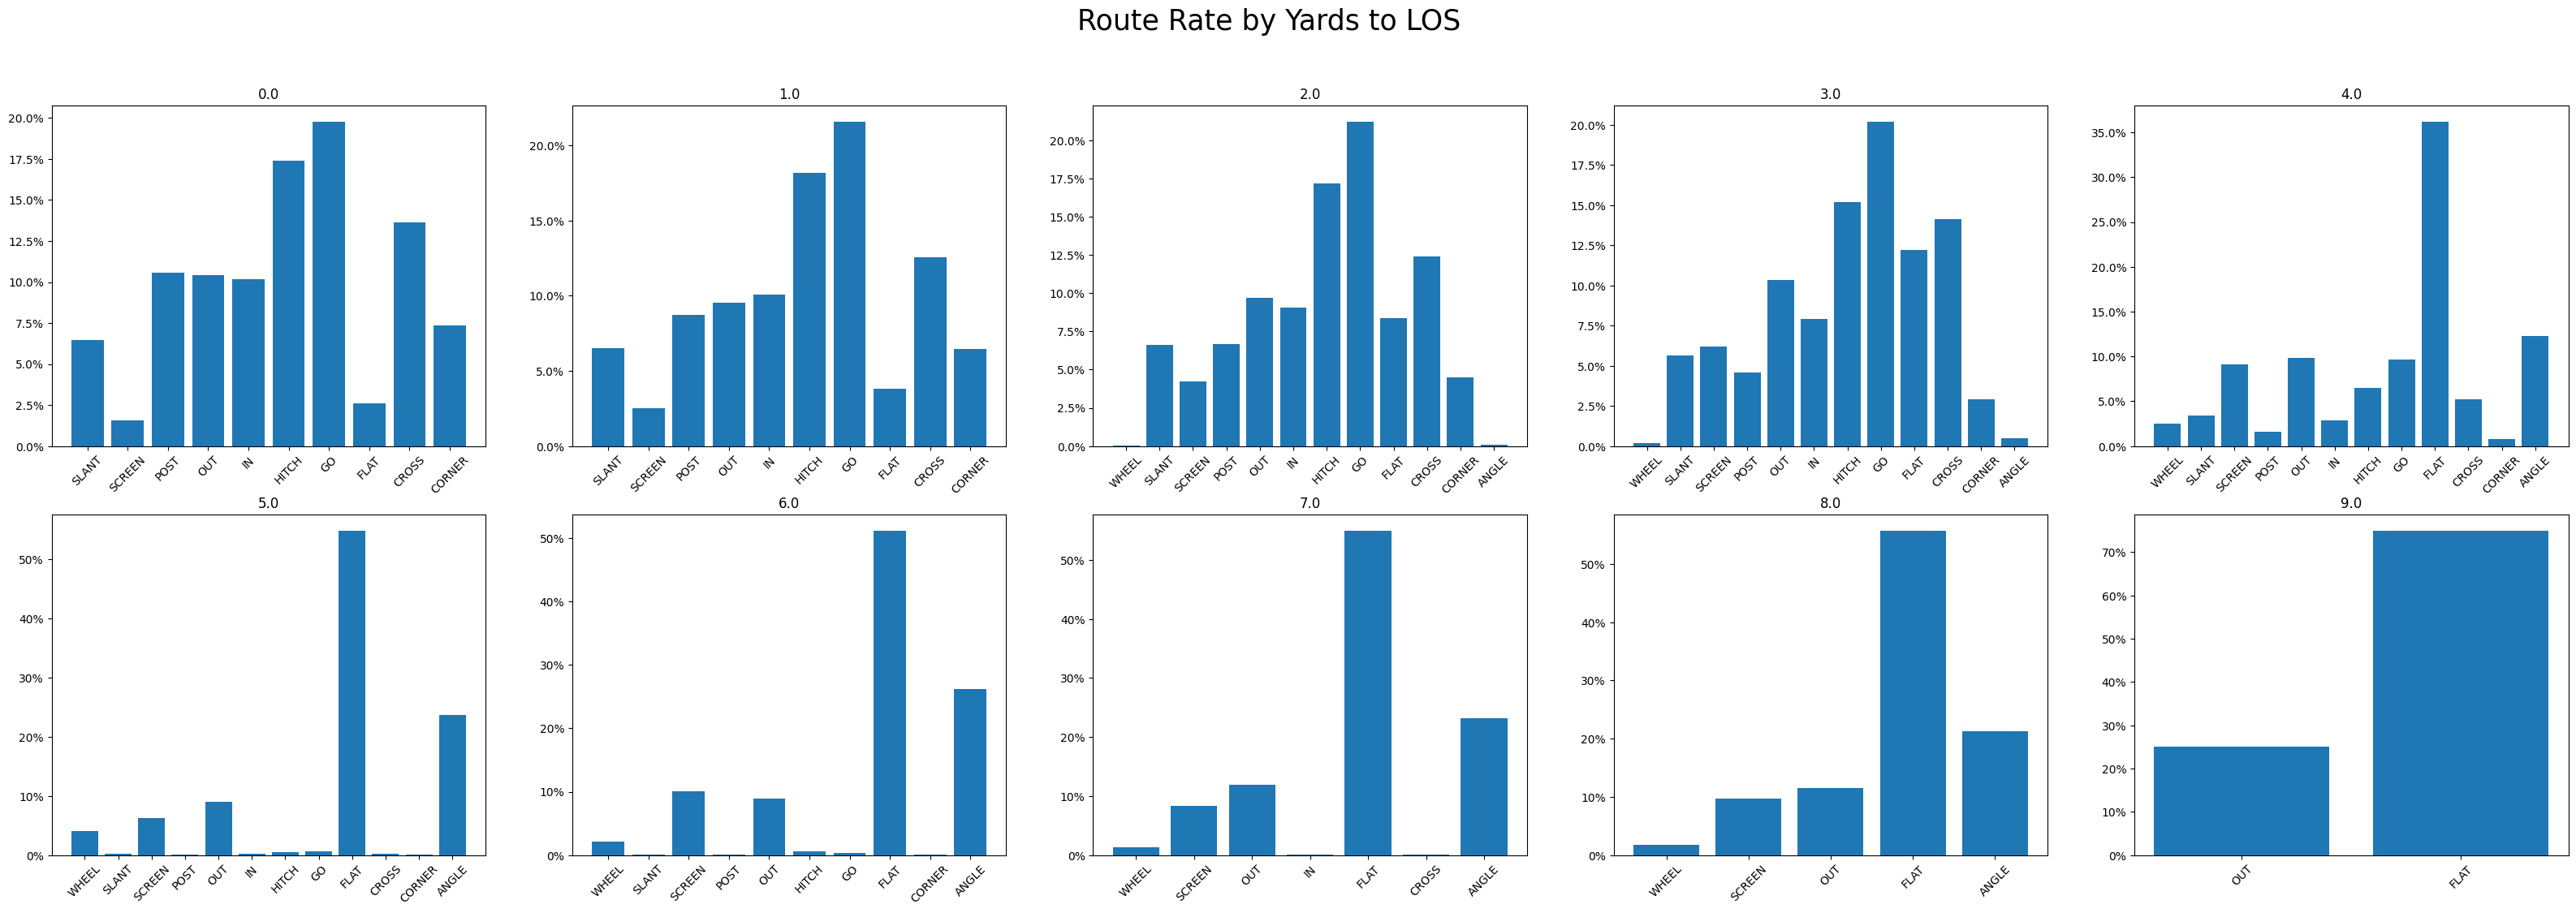

In [74]:
fig, ax = plt.subplots(2,5,figsize=(40,12),facecolor='#ffff')
formations = routeYdsToLOS['distToLOS'].unique()

for formation in range(len(routeYdsToLOS['distToLOS'].unique())):
  if formation <= 4:
    ax[0][formation].bar(routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['route_rate'])
    ax[0][formation].set_xticks(routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], rotation=45)
    ax[0][formation].set_title(formations[formation])
    ax[0][formation].yaxis.set_major_formatter(mtick.PercentFormatter())
  elif formation <= 9:
    ax[1][formation-5].bar(routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['route_rate'].round(2))
    ax[1][formation-5].set_xticks(routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], rotation=45)
    ax[1][formation-5].set_title(formations[formation])
    ax[1][formation-5].yaxis.set_major_formatter(mtick.PercentFormatter())
  else:
    ax[2][formation-10].bar(routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['route_rate'].round(2))
    ax[2][formation-10].set_xticks(routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], routeYdsToLOS[routeYdsToLOS['distToLOS']==formations[formation]]['routeRan'], rotation=45)
    ax[2][formation-10].set_title(formations[formation])
    ax[2][formation-10].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle('Route Rate by Yards to LOS', fontsize=25)

plt.savefig(
    './visuals/RouteRateByYdsToLOS.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)

Relative yards to the LOS would be beneficial to have in the model because it looks like those lined up at WR (<3 yards from LOS) primarily run GO/HITCH routes whereas those lined up in the backfield (>3 yards from LOS) primarily run FLAT routes and angles.

# Distance to Offensive Players

Use the distance to each offensive player to see if there is a difference in routes based on distance to each offensive player.

In [6]:
tracking.select('1_off_first(dist)','routeRan').show(5)

+------------------+--------+
| 1_off_first(dist)|routeRan|
+------------------+--------+
|1.1388590782006378|      GO|
| 4.876474136094643|  SCREEN|
|  9.52899784867223|      GO|
|  3.67185239354743|    FLAT|
|1.4598630072715708|      GO|
+------------------+--------+
only showing top 5 rows



In [49]:
avgDist = tracking.groupby(['gameId','playId','nflId']).agg({'1_off_first(dist)':'mean'})
avgDist = avgDist.withColumn('distToNearestOff',floor(col('avg(1_off_first(dist))')))
avgDist.select(min('distToNearestOff'),max('distToNearestOff')).show()
avgDist = avgDist.withColumn("groupDistToNearestOff", when((col('distToNearestOff')>0) & (col('distToNearestOff')<=2),'0-2').\
                                              when((col('distToNearestOff')>2) & (col('distToNearestOff')<=4),'2-4').\
                                              when((col('distToNearestOff')>4) & (col('distToNearestOff')<=6),'4-6').\
                                              when((col('distToNearestOff')>6) & (col('distToNearestOff')<=8),'6-8').\
                                              when((col('distToNearestOff')>8) & (col('distToNearestOff')<=10),'8-10').\
                                              when((col('distToNearestOff')>10) & (col('distToNearestOff')<=12),'10-12').\
                                              when((col('distToNearestOff')>12) & (col('distToNearestOff')<=14),'12-14').\
                                              when((col('distToNearestOff')>14) & (col('distToNearestOff')<=17),'14-17'))

+---------------------+---------------------+
|min(distToNearestOff)|max(distToNearestOff)|
+---------------------+---------------------+
|                    0|                   17|
+---------------------+---------------------+



In [50]:
avgDist = avgDist.toPandas()
avgDist['gameId'] = avgDist['gameId'].astype(int)
avgDist['playId'] = avgDist['playId'].astype(int)
avgDist['nflId'] = avgDist['nflId'].astype(int)
avgDist = avgDist.merge(player_play[['gameId','playId','nflId','routeRan']],how='left',on=['gameId','playId','nflId'])
# roundDist = tracking.withColumn('distToNearestOff',floor(col('1_off_first(dist)')))
totalRoutesDist = avgDist.groupby('groupDistToNearestOff').agg({'playId':'count'}).reset_index()
routesRanDist = avgDist.groupby(by=['groupDistToNearestOff','routeRan']).agg({'playId':'count'}).reset_index()
# routeRate = totalRoutesDist.join(routesRanDist,how='left',on='distToNearestOff')
# routeRate.show(5)

In [63]:
routeRate = totalRoutesDist.merge(routesRanDist,how='left',on='groupDistToNearestOff')

In [67]:
routeRate['route_rate'] = routeRate['playId_y'] / routeRate['playId_x']
# routeRate = routeRate.sort_values(by=['groupDistToNearestOff','routeRan'],ascending=[True,False]).reset_index(drop=True)
routeRate['route_rate'] = (routeRate['route_rate']*100).round(2)
# routeRate = routeRate[(routeRate['distToLOS']>=0) & (routeRate['distToLOS']<=10)]
routeRate['groupDistToNearestOff'] = pd.Categorical(routeRate['groupDistToNearestOff'], ["0-2", "2-4", "4-6","6-8","8-10","10-12","12-14","14-17"])
routeRate = routeRate.sort_values(by=['groupDistToNearestOff','routeRan'],ascending=[True,False]).reset_index(drop=True)
routeRate.head()

,groupDistToNearestOff,playId_x,routeRan,playId_y,route_rate
0,0-2,19467,WHEEL,179,0.92
1,0-2,19467,SLANT,533,2.74
2,0-2,19467,SCREEN,986,5.06
3,0-2,19467,POST,842,4.33
4,0-2,19467,OUT,2029,10.42


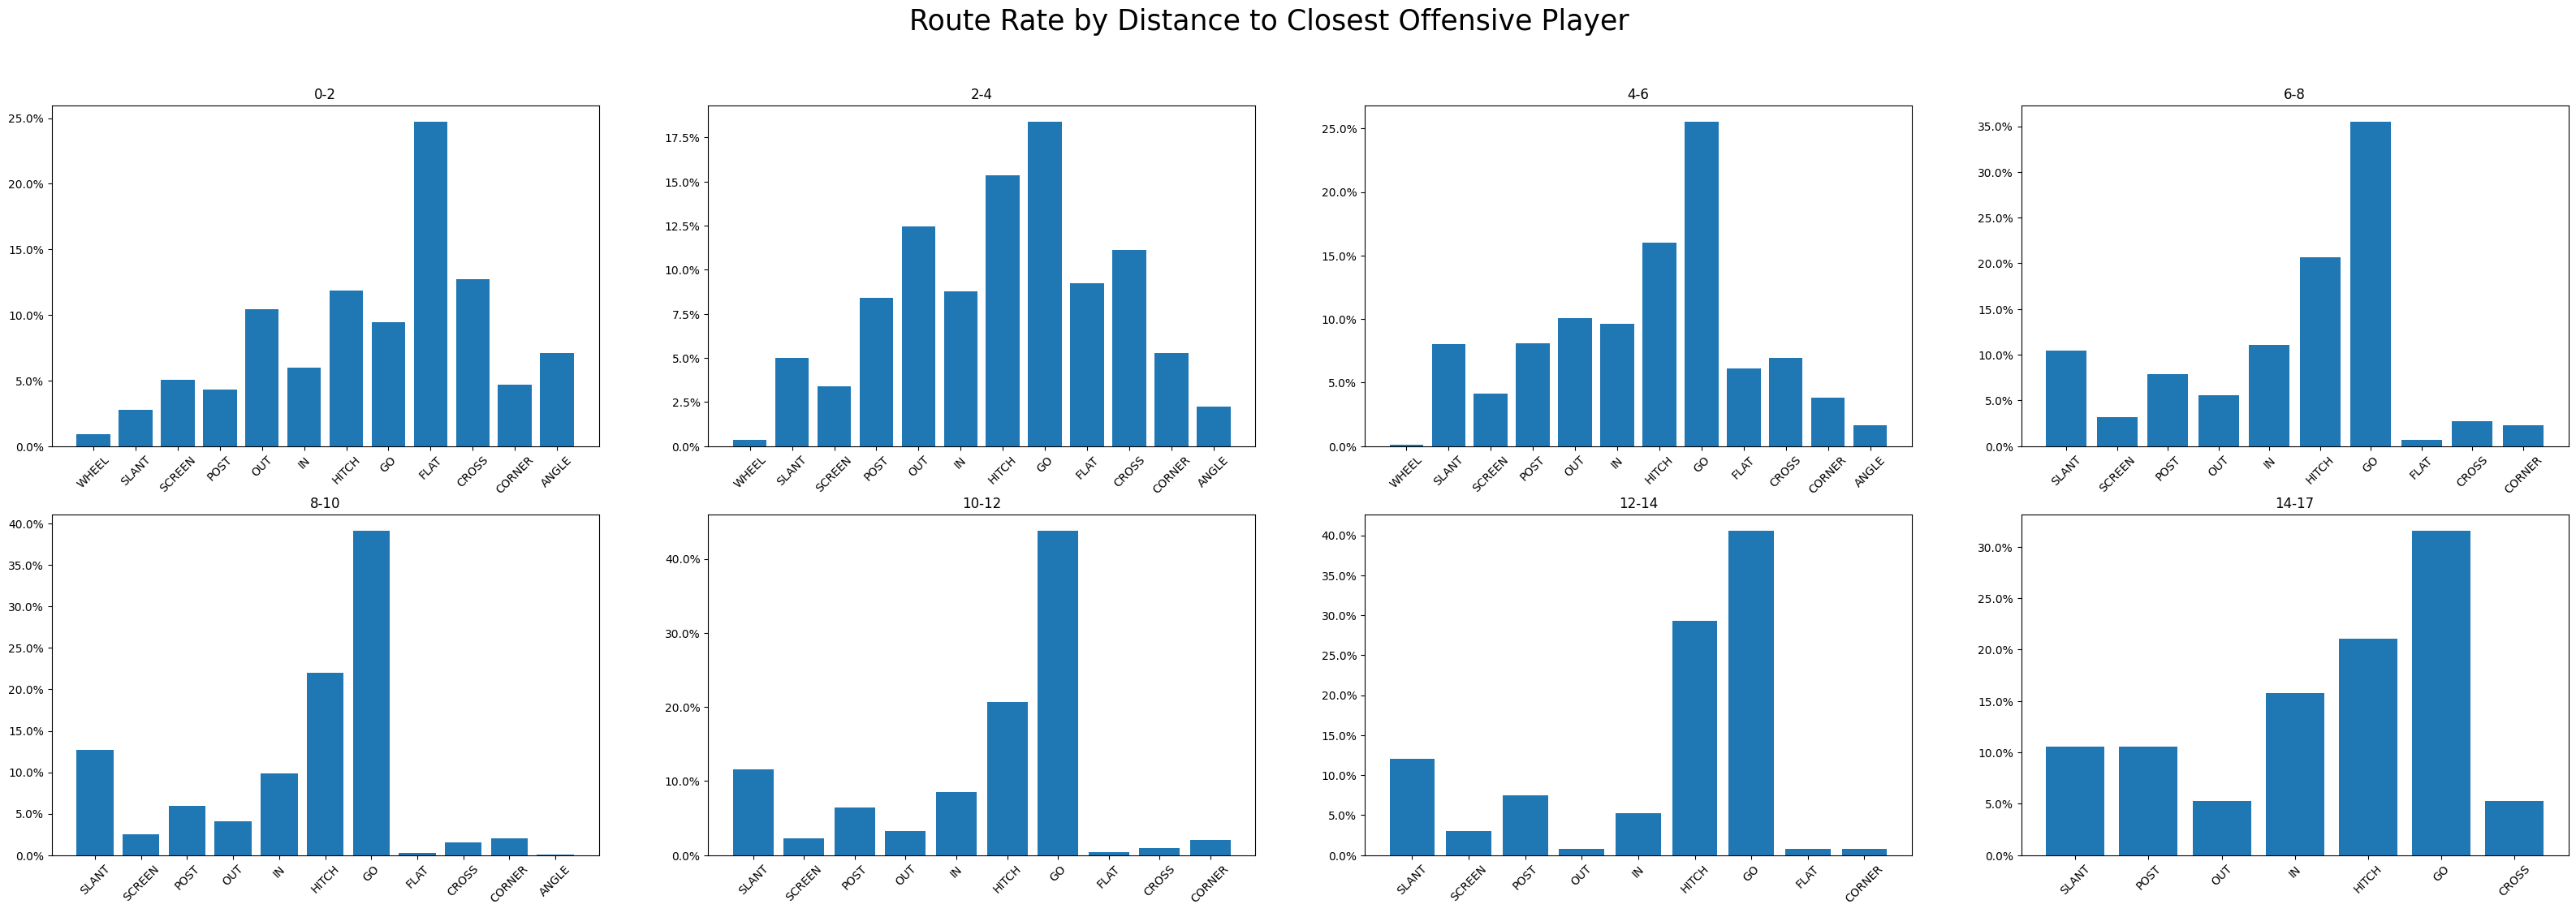

In [68]:
fig, ax = plt.subplots(2,4,figsize=(40,12),facecolor='#ffff')
formations = routeRate['groupDistToNearestOff'].unique()

for formation in range(len(routeRate['groupDistToNearestOff'].unique())):
  if formation <= 3:
    ax[0][formation].bar(routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['route_rate'])
    ax[0][formation].set_xticks(routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], rotation=45)
    ax[0][formation].set_title(formations[formation])
    ax[0][formation].yaxis.set_major_formatter(mtick.PercentFormatter())
  elif formation <= 8:
    ax[1][formation-4].bar(routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['route_rate'].round(2))
    ax[1][formation-4].set_xticks(routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], rotation=45)
    ax[1][formation-4].set_title(formations[formation])
    ax[1][formation-4].yaxis.set_major_formatter(mtick.PercentFormatter())
  else:
    ax[2][formation-10].bar(routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['route_rate'].round(2))
    ax[2][formation-10].set_xticks(routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], routeRate[routeRate['groupDistToNearestOff']==formations[formation]]['routeRan'], rotation=45)
    ax[2][formation-10].set_title(formations[formation])
    ax[2][formation-10].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.suptitle('Route Rate by Distance to Closest Offensive Player', fontsize=25)

plt.savefig(
    './visuals/RouteRateByDistToNearestOff.png',
#     transparent=False,
    bbox_inches='tight',
#     facecolor=fig.get_facecolor('#ffff')
)